In [ ]:
cipcodes = {1:"AGRICULTURE, AGRICULTURE OPERATIONS, AND RELATED SCIENCES.",\
            3: "NATURAL RESOURCES AND CONSERVATION", 4: "ARCHITECTURE AND RELATED SERVICES.",\
            5: "AREA, ETHNIC, CULTURAL, AND GENDER STUDIES.", 9: "COMMUNICATION, JOURNALISM, AND RELATED PROGRAMS.",\
            10: "COMMUNICATIONS TECHNOLOGIES/TECHNICIANS AND SUPPORT SERVICES.", 11: "COMPUTER AND INFORMATION SCIENCES AND SUPPORT SERVICES.",\
            12: "PERSONAL AND CULINARY SERVICES.",  13: "EDUCATION.", 14: "ENGINEERING.",\
            15: "ENGINEERING TECHNOLOGIES/TECHNICIANS.", 16: "FOREIGN LANGUAGES, LITERATURES, AND LINGUISTICS.",\
            19: "FAMILY AND CONSUMER SCIENCES/HUMAN SCIENCES.", 22: "LEGAL PROFESSIONS AND STUDIES.",\
            23: "ENGLISH LANGUAGE AND LITERATURE/LETTERS.", 24: "LIBERAL ARTS AND SCIENCES, GENERAL STUDIES AND HUMANITIES.",\
            25: "LIBRARY SCIENCE.",  26: "BIOLOGICAL AND BIOMEDICAL SCIENCES.", 27: "MATHEMATICS AND STATISTICS.",\
            28: "RESERVE OFFICER TRAINING CORPS (JROTC, ROTC).", 29: "MILITARY TECHNOLOGIES.",\
            30: "MULTI/INTERDISCIPLINARY STUDIES.",         31: "PARKS, RECREATION, LEISURE, AND FITNESS STUDIES.",\
            32: "BASIC SKILLS.", 33: "CITIZENSHIP ACTIVITIES.", 34: "HEALTH-RELATED KNOWLEDGE AND SKILLS.",\
            35: "INTERPERSONAL AND SOCIAL SKILLS.",         36: "LEISURE AND RECREATIONAL ACTIVITIES.",\
            37: "PERSONAL AWARENESS AND SELF-IMPROVEMENT.", 38: "PHILOSOPHY AND RELIGIOUS STUDIES.",\
            39: "THEOLOGY AND RELIGIOUS VOCATIONS.",        40: "PHYSICAL SCIENCES.",\
            41: "SCIENCE TECHNOLOGIES/TECHNICIANS.",        42: "PSYCHOLOGY.",\
            43: "SECURITY AND PROTECTIVE SERVICES.",        44: "PUBLIC ADMINISTRATION AND SOCIAL SERVICE PROFESSIONS.",\
            45: "SOCIAL SCIENCES.",                                  46: "CONSTRUCTION TRADES.",\
            47: "MECHANIC AND REPAIR TECHNOLOGIES/TECHNICIANS.",     48: "PRECISION PRODUCTION.",\
            49: "TRANSPORTATION AND MATERIALS MOVING.",              50: "VISUAL AND PERFORMING ARTS.",\
            51: "HEALTH PROFESSIONS AND RELATED CLINICAL SCIENCES.", 52: "BUSINESS, MANAGEMENT, MARKETING, AND RELATED SUPPORT SERVICES.",\
            53: "HIGH SCHOOL/SECONDARY DIPLOMAS AND CERTIFICATES.",  54: "HISTORY" }

carnegie = { 15: "Doctoral/Research Universities--Extensive",\
            16: "Doctoral/Research Universities--Intensive",\
            21: "Masters Colleges and Universities I",\
            22: "Masters Colleges and Universities II",\
            31: "Baccalaureate Colleges--Liberal Arts",\
            32: "Baccalaureate Colleges--General",\
            33: "Baccalaureate/Associates Colleges",\
            40: "Associates Colleges",\
            51: "Theological seminaries and other specialized faith-related institutions",\
            52: "Medical schools and medical centers",\
            53: "Other separate health profession schools",\
            54: "Schools of engineering and technology",\
            55: "Schools of business and management",\
            56: "Schools of art, music, and design",\
            57: "Schools of law",\
            58: "Teachers colleges",\
            59: "Other specialized institutions",\
            60: "Tribal colleges",\
            -2: "Not applicable, not in Carnegie universe (not accredited or nondegree-granting)" }

In [6]:
import pandas as pd 

outcomes    = pd.read_csv('../data/Most-Recent-Cohorts-Field-of-Study.csv') # outcomes

insts       = pd.read_csv('../data/hd2020.csv', encoding='cp1252')

# Pell > No-Pell

In [7]:
unitids = list(insts.loc[insts['INSTSIZE'] >= 3, 'UNITID'].values)

outcomes = outcomes[outcomes['UNITID'].isin(unitids)]


outcomes['CS']                      = outcomes['CIPCODE'].astype(str).apply(lambda x: (len(x)==4) and (x.startswith('11')))

outcomes                            = outcomes[outcomes['EARN_COUNT_WNE_1YR']      != 'PS']
outcomes                            = outcomes[outcomes['EARN_COUNT_PELL_WNE_1YR'] != 'PS']

outcomes['EARN_COUNT_WNE_1YR']      = outcomes['EARN_COUNT_WNE_1YR'].astype(int)
outcomes['EARN_COUNT_PELL_WNE_1YR'] = outcomes['EARN_COUNT_PELL_WNE_1YR'].astype(int)

outcomes = outcomes.rename(columns={'EARN_COUNT_WNE_1YR': 'total_count', \
                                    'EARN_COUNT_PELL_WNE_1YR': 'pell_count'})

outcomes['nopell_count'] = outcomes['total_count'] - outcomes['pell_count']

# outcomes[['INSTNM', 'total_count', 'pell_count', 'nopell_count']]

a = outcomes[outcomes['CIPCODE'] == 1107]

# a[['pell_count', 'nopell_count']]

outcomes['weird'] = outcomes['pell_count'] > outcomes['nopell_count']

outcomes[['weird', 'CIPCODE']]

nopell = outcomes[['UNITID', 'INSTNM', 'CS', 'nopell_count']]
nopell['pell'] = False
# nopell.rename(columns={'EARN_COUNT_NOPELL_WNE_4YR':'Count'}, inplace=True)
# nopell = nopell[nopell['Count'] != 'PS']
# nopell['Count']  = nopell['Count'].astype(float)



pell = outcomes[['UNITID', 'INSTNM', 'CS', 'pell_count']]
pell['pell'] = True
# pell.rename(columns={'EARN_COUNT_PELL_WNE_4YR':'Count'}, inplace=True)
# pell = pell[pell['Count'] != 'PS']
# pell['Count']  = pell['Count'].astype(float)

pell_stats = pell.groupby(['UNITID', 'INSTNM', 'CS', 'pell'])['pell_count'].sum().reset_index()
nopell_stats = nopell.groupby(['UNITID', 'INSTNM', 'CS', 'pell'])['nopell_count'].sum().reset_index()

merged = pd.merge(pell_stats, nopell_stats, on=['UNITID', 'CS'])
merged#['Count_x'] >= merged['Count_y']

# CS Completions (IPEDS)

In [108]:
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
from tqdm import tqdm
import numpy as np
import math
%matplotlib inline

# 2004, 2008, 2011

import warnings
warnings.filterwarnings("ignore")

unis    = pd.read_csv('../data/hd2020.csv', encoding='cp1252')
fnames  = glob('../data/IPEDS/*_A/*_rv.csv')+glob('../data/IPEDS/*_a.csv')
dfs     = []

for fname in tqdm(fnames): 

    year = int(fname.split('/')[-1].split('_')[0][1:])
    if year <= 2001:
        continue 

    df          = pd.read_csv(fname, index_col=0)
    df          = df.rename(columns={col: col.upper().strip() for col in df.columns})
    df          = df[df['AWLEVEL'].apply(lambda x: x in [5, 7, 9, 17, 18, 19])]
    df['cs']    = df['CIPCODE'].apply(lambda x: (x>=11) & (x<12))
    df['year']  = year
    df['ugd']   = df['AWLEVEL'] == 5
    df['mst']   = df['AWLEVEL'] == 7
    df['phd']   = df['AWLEVEL'] >  7

    dfs.append(df)

all_dfs = pd.concat(dfs)

100%|██████████| 23/23 [00:25<00:00,  1.13s/it]


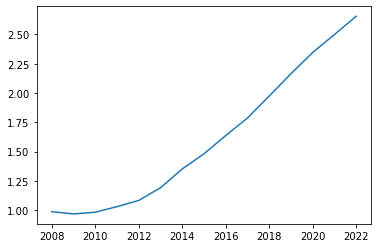

In [110]:
all_dfs = all_dfs[all_dfs['ugd']]

cs = all_dfs[all_dfs['cs']]['CTOTALT'].sum()
all = all_dfs['CTOTALT'].sum()

merged = pd.merge(all_dfs, unis, left_index=True, right_on='UNITID')

cs_pct_ipeds = merged.groupby(['year']).apply(lambda x: 100*x[x['cs']]['CTOTALT'].sum()/x['CTOTALT'].sum())

plt.plot(cs_pct_ipeds)

### INSTSIZE

In [21]:
cs_pct = merged.groupby(['year', 'INSTSIZE']).apply(lambda x: 100*x[x['cs']]['CTOTALT'].sum()/x['CTOTALT'].sum())

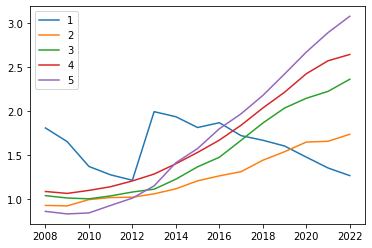

In [22]:
cs_pct = cs_pct.reset_index().dropna()
for size in cs_pct['INSTSIZE'].unique():
    if size < 0: 
        continue
    filtered = cs_pct[cs_pct['INSTSIZE'] == size]
    plt.plot(filtered['year'], filtered[0], label=size)

plt.legend()

In [33]:
merged[merged['cs']].groupby('UNITID')['CTOTALT'].sum().sort_values()

UNITID
146241        0.0
161341        0.0
133508        0.0
119173        0.0
107558        0.0
           ...   
228787    16250.0
211440    18169.0
139755    21510.0
433387    34222.0
163204    39472.0
Name: CTOTALT, Length: 1696, dtype: float64

In [27]:
merged[merged['INSTSIZE'] == 1]['CARNEGIE'].replace(carnegie).value_counts()

Baccalaureate Colleges--General                                                    62486
Baccalaureate Colleges--Liberal Arts                                               56742
Not applicable, not in Carnegie universe (not accredited or nondegree-granting)    37279
Theological seminaries and other specialized faith-related institutions            28930
Associates Colleges                                                                11077
Masters Colleges and Universities I                                                 9417
Schools of art, music, and design                                                   9287
Masters Colleges and Universities II                                                8573
Baccalaureate/Associates Colleges                                                   6446
Other separate health profession schools                                            5476
Other specialized institutions                                                      3618
Schools of business a

### CARNEGIE

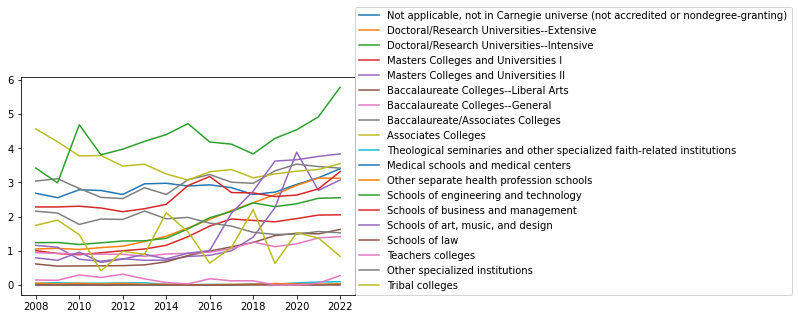

In [23]:
col = 'CARNEGIE'

cs_pct = merged.groupby(['year', col]).apply(lambda x: 100*x[x['cs']]['CTOTALT'].sum()/x['CTOTALT'].sum())
cs_pct = cs_pct.reset_index().dropna()
for col_val in cs_pct[col].unique():
    if size < 0: 
        continue
    filtered = cs_pct[cs_pct[col] == col_val]
    plt.plot(filtered['year'], filtered[0], label=carnegie[col_val])

plt.legend(loc=(1, 0))

In [ ]:
col = 'CARNEGIE'

cs_pct = merged.groupby(['year', col]).apply(lambda x: 100*x[x['cs']]['CTOTALT'].sum()/x['CTOTALT'].sum())
cs_pct = cs_pct.reset_index().dropna()
for col_val in cs_pct[col].unique():
    if size < 0: 
        continue
    filtered = cs_pct[cs_pct[col] == col_val]
    plt.plot(filtered['year'], filtered[0], label=carnegie[col_val])

plt.legend(loc=(1, 0))

# College Scorecard Data

In [23]:
from tqdm import tqdm 
fnames = glob('../../CollegeScorecardData/College_Scorecard_Raw_Data_04082024/Field*')

scorecards = []

for fname in tqdm(fnames): 
    df = pd.read_csv(fname)
    df['year'] = int(fname.split('/')[-1].split('_')[0][-4:])
    scorecards.append(df)

all_sc = pd.concat(scorecards)

100%|██████████| 5/5 [00:13<00:00,  2.69s/it]


In [55]:
# merged = pd.merge(insts, all_sc, left_on='UNITID', right_on='UNITID')
# sc_agg = all_sc.groupby(['UNITID', 'year', 'cs']).sum()
# all_sc.replace('PS', None).dropna(axis=1).shape
# sc_agg = sc_agg.reset_index()

## Comparison 1 (macro)

In [24]:
all_sc['cs'] = all_sc['CIPCODE'].astype(str).apply(lambda x: len(x)==4 and x.startswith('11'))
cs_pct_sc = all_sc.groupby('year').apply(lambda x: x[x['cs']]['IPEDSCOUNT1'].sum()/x['IPEDSCOUNT1'].sum())
cs_pct_sc.index = range(2014, 2019)

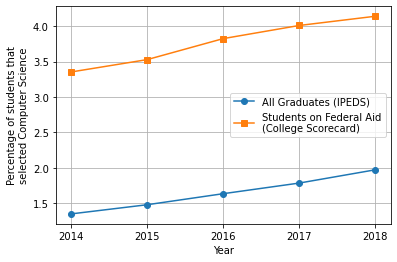

In [52]:
# plt.plot(cs_pct_ipeds.loc[2014:2019], marker='s', label='CS % IPEDS');
plt.plot(cs_pct_ipeds.loc[cs_pct_sc.index], marker='o', label='All Graduates (IPEDS)');
# plt.twinx()
plt.plot((100*cs_pct_sc), marker='s', label='Students on Federal Aid\n(College Scorecard)');
plt.legend()
plt.grid()

plt.ylabel('Percentage of students that\nselected Computer Science')
plt.xlabel('Year')

plt.xticks(range(2014, 2019));

## Comparison 2 (breakdown)

Scorecard Data

In [ ]:
sc_stats = sc_agg.groupby(['UNITID', 'year']).apply(lambda x: x[x['cs']]['IPEDSCOUNT1'].sum()/x['IPEDSCOUNT1'].sum())
sc_stats = sc_stats.reset_index().dropna().rename(columns={0: 'cs_aid_pct'})
sc_stats['year2'] = sc_stats['year'].apply(lambda x: 2000+int(str(x)[:2]))

IPEDS Data

In [111]:
all_dfs2 = all_dfs.reset_index().rename(columns={'index': 'UNITID'})
ipeds_cs_pct = all_dfs2.groupby(['UNITID', 'year']).apply(lambda x: x[x['cs']]['CTOTALT'].sum()/x['CTOTALT'].sum())
ipeds_cs_pct = ipeds_cs_pct.dropna().reset_index().rename(columns={0: 'cs_ipeds_pct'})

In [114]:
merged = pd.merge(sc_stats, ipeds_cs_pct, left_on=['UNITID', 'year2'], right_on=['UNITID', 'year'])

In [115]:
merged2

,UNITID,year_x,cs_aid_pct,year2,year_y,cs_ipeds_pct
0,100654.0,1415,0.051805,2014,2014,0.013771
1,100654.0,1516,0.038251,2015,2015,0.031690
2,100654.0,1617,0.038037,2016,2016,0.020047
3,100654.0,1718,0.046045,2017,2017,0.017660
4,100654.0,1819,0.048148,2018,2018,0.029586
...,...,...,...,...,...,...
12445,491710.0,1819,0.000000,2018,2018,0.000000
12446,492069.0,1819,0.000000,2018,2018,0.000000
12447,492689.0,1819,0.000000,2018,2018,0.000000
12448,492801.0,1819,0.000000,2018,2018,0.000000


In [117]:
insts.head()[:3]

,UNITID,INSTNM,IALIAS,ADDR,CITY,STABBR,ZIP,FIPS,OBEREG,CHFNM,...,CBSATYPE,CSA,NECTA,COUNTYCD,COUNTYNM,CNGDSTCD,LONGITUD,LATITUDE,DFRCGID,DFRCUSCG
0,100654,Alabama A & M University,AAMU,4900 Meridian Street,Normal,AL,35762,1,5,"Dr. Andrew Hugine, Jr.",...,1,290,-2,1089,Madison County,105,-86.568502,34.783368,109,1
1,100663,University of Alabama at Birmingham,,Administration Bldg Suite 1070,Birmingham,AL,35294-0110,1,5,Ray L. Watts,...,1,142,-2,1073,Jefferson County,107,-86.799345,33.505697,95,1
2,100690,Amridge University,Southern Christian University Regions University,1200 Taylor Rd,Montgomery,AL,36117-3553,1,5,Michael C.Turner,...,1,388,-2,1101,Montgomery County,102,-86.174010,32.362609,126,2


In [118]:
merged2 = pd.merge(merged, insts, left_on='UNITID', right_on='UNITID')

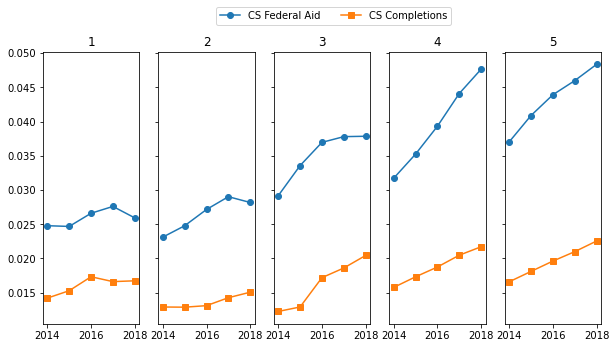

In [158]:
grobj = merged2.groupby(['INSTSIZE', 'year2'])

aid_stats = grobj.apply(lambda x: pd.Series({'mean': x['cs_aid_pct'].mean(), 'std': x['cs_aid_pct'].std()})).reset_index()
cs_stats = grobj.apply(lambda x: pd.Series({'mean': x['cs_ipeds_pct'].mean(), 'std': x['cs_ipeds_pct'].std()})).reset_index()

fig, axs = plt.subplots(1, 5, figsize=(10, 5), sharey=True)

sizes = [1, 2, 3, 4, 5]

for i, size in enumerate(sizes):
    # if size < 0: 
    #     continue
    filtered_aids = aid_stats[aid_stats['INSTSIZE']==size]
    filtered_cs   = cs_stats[cs_stats['INSTSIZE']==size]

    axs[i].plot(filtered_aids['year2'], filtered_aids['mean'], label='CS Federal Aid', marker='o')
    axs[i].plot(filtered_cs['year2'], filtered_cs['mean'], label='CS Completions', marker='s')

    axs[i].set_title(size)

plt.legend(loc=(-3, 1.1), ncol=2);

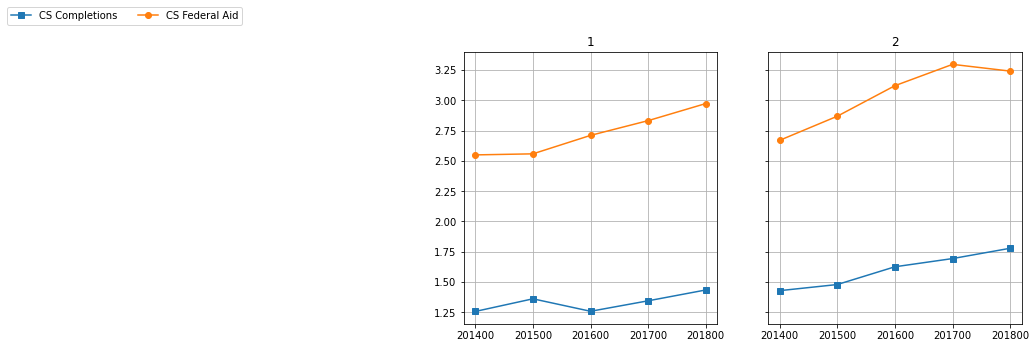

In [171]:
col       = 'HBCU'
grobj     = merged2.groupby([col, 'year2'])

aid_stats = grobj.apply(lambda x: pd.Series({'mean': x['cs_aid_pct'].mean(), 'std': x['cs_aid_pct'].std()})).reset_index()
cs_stats  = grobj.apply(lambda x: pd.Series({'mean': x['cs_ipeds_pct'].mean(), 'std': x['cs_ipeds_pct'].std()})).reset_index()


# sizes = [1, 2, 3, 4, 5]
unique_vals = merged2[col].unique()

fig, axs  = plt.subplots(1, len(unique_vals), figsize=(10, 5), sharey=True)

for i, val in enumerate(unique_vals):
    
    filtered_aids = 100*aid_stats[aid_stats[col]==val]
    filtered_cs   = 100*cs_stats[cs_stats[col]==val]

    axs[i].plot(filtered_cs['year2'], filtered_cs['mean'], label='CS Completions', marker='s')
    axs[i].plot(filtered_aids['year2'], filtered_aids['mean'], label='CS Federal Aid', marker='o')

    axs[i].set_title(val)
    axs[i].grid()

plt.legend(loc=(-3, 1.1), ncol=2);